![Kickstarter](misc/kickstarter_logo.png)

# Results of the Analysis of Kickstarter Projects
#### Data taken from Kaggle (https://www.kaggle.com/kemical/kickstarter-projects)

---
### Table of Contents:
* [1.)](#introduction) About Kickstarter and its Projects
* [2.)](#content_of_nb) Goal of this Notebook (Questions to be answered)
* [3.)](#main_categories_analysis) Analysis of the Main Categories
* [4.)](#price_analysis) Analysis of the Project Sizes (regarding the Prices)
* [5.)](#runtime_analysis) Analysis of the Project Runtimes
* [6.)](#combined_analysis) Combined Analysis of the first three questions
* [7.)](#result) Results



---
<a id='introduction'></a>
## 1.) About Kickstarter and its Projects


Kickstarter is an American public-benefit corporation which offers a global crowdfunding platform focused on creativity and merchandising. People can raise money for their own Ideas - they insert a new project by describing what their idea is about, how much money they need and adding a deadline for the project. Users of the platform can then decide to pledge money for projects they find interesting. <br>
One Example for a very successful project on Kickstarter is the Game <a href="https://explodingkittens.com/">Exploding Kittens</a>. They raised 8,782,57 USD for their idea (even though they only needed 10,000 USD). They had a total of 219382 backers who nowadays like to play the game which is for “people who are into kittens and explosions and laser beams and sometimes goats”

---
<a id='content_of_nb'></a>
## 2.) Goal of this Notebook (Questions to be answered)

In this notebook, I'm going to take a look at the different kind of projects and try to understand if there are characteristics or trends regarding projects who are more successful than others are. The explorative analysis showed, that there indeed are some interesting questions which can be asked. In this notebook, there are going to be three main questions with one follow-up question combining insights gained beforehand. <br>
The questions are:
- Are there any significant differences between the main categories regarding success ratio? Are there certain categories which have a much higher chance of succeeding/failing than others?
- Are smaller projects more likely to succeed than others? How much does the goal size have to do with the chance of success?
- Did the average project runtime change throughout the years? What average project runtime do projects have today?
- Can the first three questions be combined to gain some additional insights?

#### Imports & Data

In [1]:
import pandas as pd
import numpy as npa
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict

filename = 'data/ks-projects-201801.csv'
df = pd.read_csv(filename)

#### Original Format

In [2]:
df.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00


A quick look at the data shows that...
- there are some columns which aren't necessary for the questions of this notebook and therefore can be dropped
- some of the columns need to be converted to take full advantage of them (e.g. column 'launched')
- there are interesting combinations of columns which could offer some more information (e.g. the runtime of a project)

In [3]:
# remove columns which aren't used during analysis
df.drop(['usd pledged', 'usd_pledged_real', 'usd_goal_real'], axis=1, inplace=True)

# convert launched and deadline columns
from datetime import datetime
df['launched'] = df['launched'].apply(lambda x: datetime.strptime(x[:10], "%Y-%m-%d"))
df['deadline'] = df['deadline'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df['year_deadline'] = df['deadline'].apply(lambda x: x.year)

# calculate the runtime of the project
df['project_runtime'] = df['deadline'] - df['launched']
df['project_runtime'] = df['project_runtime'].apply(lambda x: int(x.days)) # project runtime in days

Since I'm not going to use any kind of machine learning for this analysis, I'm not going to convert any categorical values.

#### Format after Conversion

In [4]:
df.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,year_deadline,project_runtime
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,2015,59
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,2017,60
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,2013,45


Now the data is in a format which can be used for further analysis.

---
<a id='main_categories_analysis'></a>
## 3.) Analysis of the Main Categories

Are there (main) categories which have a higher success ratio than others?

In [5]:
# function with general usage (therefore names etc. kept abstract)
def textplot(df, div_by, col, xlabel='_', ylabel='_', title='_', use_overall_stats=True, figsize_inches=(15, 12)):
    '''
    Plots the ratio how often the values of the 'col' column occur 
    together with the values of the 'div_by' column (pairwise)
    as a scatter plot where the data points are text annotations.
    Example: If value "Games" of column 'col' occurs 70% of the time together with value "Success" of column 'div_by', 
    the text annotation will be plotted at the coordinates ([location of "Success" on x-axis], 0.70).
    Does not work well if there are too many possible values in one of the columns (e.g. for numeric columns)!
    Args:
    - df:                          DataFrame with the data for analysis
    - div_by:                      Column with the Values for X-Axis
    - col:                         Column with the Values to be analyzed
    - xlabel(optional):            Labels for X-Axis
    - ylabel(optional):            Labels for Y-Axis
    - title(optional):             Title of the Plot
    - use_overall_stats(optional): Plot the Overall Statistics of the X-Axis Values too as red dots
    - figsize_inches(optional)     Size of the Plot
    '''
    
    # Inputhandling
    assert str(type(df)) == "<class 'pandas.core.frame.DataFrame'>", "Input df is not a pandas DataFrame."
    assert div_by in df.columns and col in df.columns, "Input columns (xcol and/or ycol) not in given DataFrame."
    assert len(figsize_inches) == 2, "Figsize needs to have a x-value and a y-value. Please enter a tuple."
    
    #Default values
    if xlabel == '_':
        xlabel = div_by
    if ylabel == '_':
        ylabel = 'Ratios'
    if title == '_':
        title = 'Ratio of ' + col + ' in ' + div_by
    
    # Create a Dictionary which holds count_values like this: 
    # ycol = Categories
    # xcol = States
    # Dictionary[Category][State] -> 0.134 (=13.4%)
    occurences_of_div_by_for_col = df.groupby([col])[div_by].value_counts(normalize=True)
    col_div_by_dict = defaultdict(dict)
    for idx, value in enumerate(occurences_of_div_by_for_col):
        col_val, div_by_val = occurences_of_div_by_for_col.index[idx]
        col_div_by_dict[col_val][div_by_val] = value
        # col_div_by_dict named after the keys to get the value
        
    # Prepare values for plotting
    X = []
    Y = []
    annotations = []
    for col_val, div_by_value_dict in col_div_by_dict.items():
        for div_by_val, value in div_by_value_dict.items():
            X.append(div_by_val)        # Values for X Axis
            Y.append(value)             # Values for Y Axis
            annotations.append(col_val) # Text

    # Build plot
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize_inches)
    ax.scatter(x=X, y=Y, s=0.01) # data point is too small to see (-> show only text)
    for idx, txt in enumerate(annotations):
        ax.annotate(txt, xy=(X[idx], Y[idx]), verticalalignment='center', horizontalalignment='center') # places the text annotation at the data point
    if use_overall_stats:
        overall_stats = df[div_by].value_counts(normalize=True)
        ax.scatter(x=list(overall_stats.index), y=list(overall_stats.values), s=100, c='r') # plots overall states ratio as red dots
        plt.legend(["red dots = overall Ratios (not grouped by category)"])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

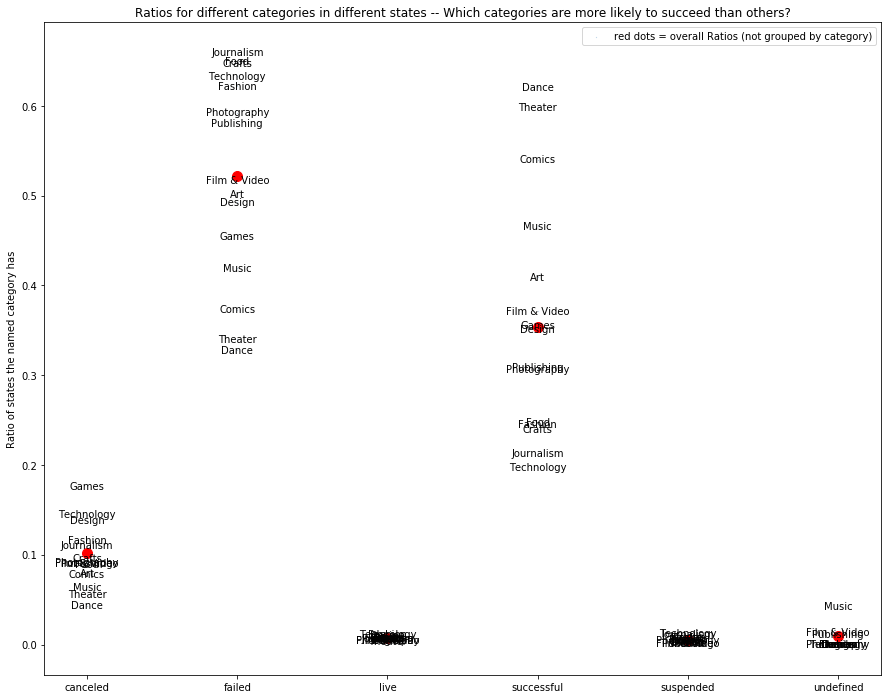

In [6]:
xlabel = ""
ylabel = "Ratio of states the named category has"
title = "Ratios for different categories in different states -- Which categories are more likely to succeed than others?"
textplot(df, 'state', 'main_category', xlabel=xlabel, ylabel=ylabel, title=title)

The above Plot shows that there indeed are some main categories which are much more likely to succeed than others. <br>
For example: The category "Dance" has succeeded in over 60% of the cases in the past - this is much higher than the average (roughly 35%). The category "Technology" on the other hand only has had succeeded in roughly 20% of the cases.

In [7]:
successful_cats = ['Dance', 'Theater', 'Comics', 'Music', 'Art']
failed_cats = ['Journalism', 'Food', 'Crafts', 'Technology', 'Fashion', 'Photography', 'Publishing']
canceled_cats = ['Games', 'Technology', 'Design', 'Fashion', 'Journalism']
unsuccessful_cats = list(set().union(failed_cats, canceled_cats)) # merges failed and canceled cats

---
<a id='price_analysis'></a>
## 4.) Analysis of the Project Sizes (regarding the Prices)

Taking a quick look at the comparison of prices for different categories, is there some characteristic about the projects which succeed/fail?

In [8]:
s1 = df.groupby(['state'])['goal'].mean() #overall avg goal per state
s2 = df.groupby(['main_category','state'])['goal'].mean().loc[successful_cats].groupby(['state']).mean() # avg goal per state for successful categories
s3 = df.groupby(['main_category','state'])['goal'].mean().loc[unsuccessful_cats].groupby(['state']).mean() # avg goal per state for unsuccessful categories
goalsizes = pd.concat([s1.rename('avg_goalsize'), s2.rename('avg_goalsize_successful_categories'), s3.rename('avg_goalsize_unsuccessful_categories')], axis=1).reset_index()
goalsizes.drop(goalsizes.loc[goalsizes['state'].isin(['live', 'suspended', 'undefined'])].index, inplace=True)
goalsizes

,state,avg_goalsize,avg_goalsize_successful_categories,avg_goalsize_unsuccessful_categories
0,canceled,86193.059649,44872.203435,65357.258696
1,failed,67346.845539,42123.175920,55498.234528
3,successful,10162.960544,5307.162505,12291.052442


This table compares the average project sizes (how much money the initiatores want to collect); the first numeric column is an overall statistic and shows, what average goal size the projects have categorized by the states. The second numeric column takes a look only at the main categories which have been observed as more successful in the previous question - those are the categories, which much more often succeed than others. The last numeric column on the other hand only takes a look at the rather unsuccessful categories. <br>
The column "avg_goalsize" already shows one important insight: Projects who are successful have on average roughly 1/7 of the goalsize of those projects who fail. This shows that smaller projects have a higher success ratio (maybe because the initiators can easier forecast the amount of effort which is needed for smaller projects than for complex projects like in Technology). The next insight is that the average goalsize for rather successful categories is much smaller (roughly 1/2) of those of unsuccessful categories. Therefore smaller projects are more likely to succeed.

---
<a id='runtime_analysis'></a>
## 5.) Analysis of the Project Runtimes

Is there some interesting trend which can be observed from the project runtimes?

In [9]:
# function with general usage (therefore names etc. kept abstract)
def plot_changes_throughout_years(df, col, div_by, xlabel='_', ylabel='_', title='_', yearcol='year_deadline', colordict=None, figsize_inches=(15, 12)):
    '''
    Plots the Changes of a Column throughout the years - the Values of the Column get categorized by Values of another Column ('div_by' Column).
    Args:
    - df:                           DataFrame with the data for analysis
    - col:                          Column with the Values to be analyzed
    - div_by:                       Column with the Values for Categorization
    - xlabel(optional):             Labels for X-Axis
    - ylabel(optional):             Labels for Y-Axis
    - title(optional):              Title of the Plot
    - yearcol(optional):            Name of the Column with the Year-Values
    - colordict(optional):          Dictionary with colors for the possible Categories (one needed for each value in 'div_by')
    - figsize_inches(optional):     Size of the Plot
    '''
    
    # Input Handling
    assert str(type(df)) == "<class 'pandas.core.frame.DataFrame'>", "Input df is not a pandas DataFrame."
    assert col in df.columns and div_by in df.columns, "Input columns (ycol and/or div_by) not in given DataFrame."
    if colordict is not None:
            assert str(type(colordict)) == "<class 'dict'>", "colordict is not a Dictionary"
    assert len(figsize_inches) == 2, "Figsize needs to have a x-value and a y-value. Please enter a tuple."
    
    # Default Values
    if xlabel == '_':
        xlabel = 'Year'
    if ylabel == '_':
        ylabel = 'Average ' + col
    if title == '_':
        title = 'Changeing ' + col + ' over the Years (divided by ' + div_by + ')'
    
    # Calculate the mean col Value for each year divided be the div_by col
    avgs_by_year_and_div = df.groupby([yearcol, div_by])[col].mean()

    # Prepare the values for plotting
    divs = []                        # Values to divide graphs by
    years = defaultdict(list)        # Values for X - Axis
    avg_col_vals = defaultdict(list) # Values for Y  - Axis
    for idx, value in enumerate(avgs_by_year_and_div):
        year, div = avgs_by_year_and_div.index[idx]
        divs.append(div)
        years[div].append(year)
        avg_col_vals[div].append(value)

    # Build the Plot
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize_inches)
    for div in set(divs):
        if colordict is not None:
            ax.plot(years[div], avg_col_vals[div], c=colordict[div], label=div)
        else:
            ax.plot(years[div], avg_col_vals[div], label=div)
    plt.legend()
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

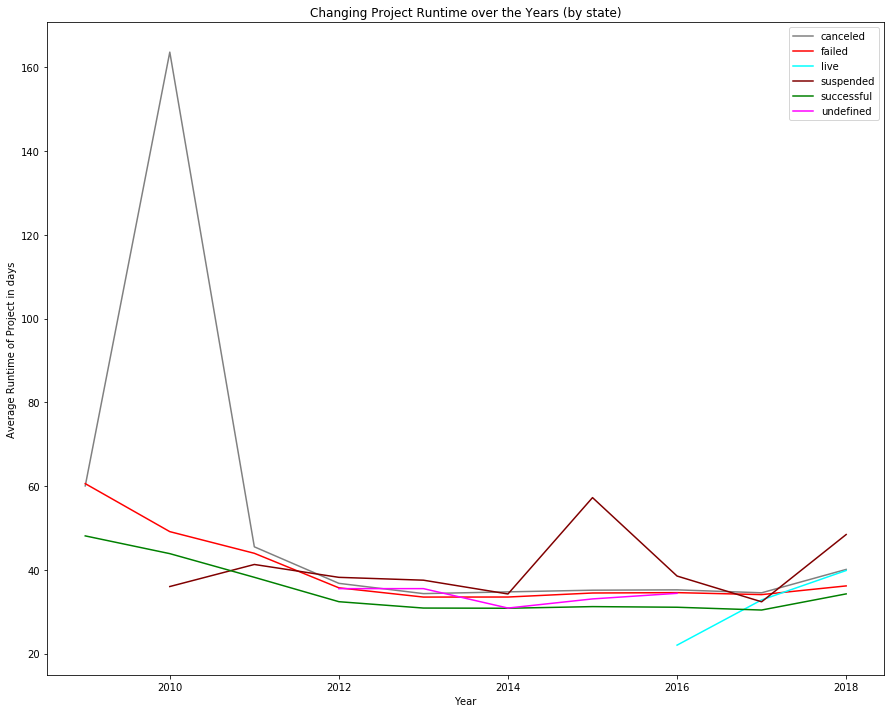

In [10]:
title = "Changing Project Runtime over the Years (by state)"
ylabel = "Average Runtime of Project in days"
xlabel = "Year"
colors = {
    'canceled': 'grey',
    'failed': 'red',
    'live': 'cyan',
    'successful': 'green',
    'suspended': 'maroon',
    'undefined': 'magenta'
}
plot_changes_throughout_years(df, 'project_runtime', 'state', xlabel=xlabel, ylabel=ylabel, title=title, colordict=colors)

On average, the project runtime has decreased over the years - Successful projects for example had a mean project runtime of roughly 45 days in 2009, nowadays the mean is roughly 30 days.

---
<a id='combined_analysis'></a>
## 6.) Combined Analysis of the first three questions

Can the insights of the first three questions be combined by taking a look at another question? <br>
Let's take a closer look at how the prices changed over the years for two categories and watch when they were the most successful.

In [11]:
# function with general usage (therefore names etc. kept abstract)
def moving_avg(df, col, k):
    '''
    Returns the Moving Average (of the k last values) of a Column.
    Function can be drastically improved -> Save the values in a list/array and add/remove one value for each iteration (TODO)!
    Args:
    - df:  DataFrame with the data
    - col: numerical column of which the moving average is going to be computed
    - k:   bigger k makes the average less sensitive regarding outliers
    Returns:
    - float
    '''
    
    # Input Handling
    assert df[col].dtype in (float, int), 'Column must be numerical'
    
    # Compute Averages
    averages = []
    for idx, row in enumerate(df[col]):
        if idx < k:
            averages.append(round(df[col].iloc[0:idx+1].mean()))
        else:
            averages.append(round(df[col].iloc[idx - k:idx].mean()))
    return averages

In [12]:
df.sort_values(by='deadline', inplace=True)
k = 10000 # value, at which the curves get smoother
moving_avgs = {}
deadlines = {}
for cat in (successful_cats + unsuccessful_cats):
    moving_avgs[cat] = moving_avg(df.loc[df['main_category'] == cat], 'goal', k)
    deadlines[cat] = df['deadline'].loc[df['main_category'] == cat]

In [13]:
# function with concrete usage for showing some stats for one category, therefore
# the function is less general then the ones above
def plot_cat_analysis(moving_avgs, deadlines, category, figsize_inches=(15, 8)):
    '''
    Plots two Graphs. 
    The first Graph shows how the goal size changed throughout the years for the given category.
    The second Graph shows for each state (successful, failed, ..) how many projects landed in this state for a given year.
    Args:
    - moving_avgs:                  Dictionary which holds the moving averages for all categories
    - deadlines:                    Dictionary which holds the deadlines for all categories
    - category:                     Category which should be analysed
    - figsize_inches(optional):     Size of the Plot
    '''
    
    # Input Handling
    assert str(type(moving_avgs)) == "<class 'dict'>", "moving_avgs is not a Dictionary"
    assert str(type(deadlines)) == "<class 'dict'>", "deadlines is not a Dictionary"
    assert str(type(moving_avgs.get(category))) != "<class 'NoneType'>", "moving_avgs has no entry for {}".format(category)
    assert len(figsize_inches) == 2, "Figsize needs to have a x-value and a y-value. Please enter a tuple."
    
    # Default Values
    if category in successful_cats:
        c = 'green'
    elif category in unsuccessful_cats:
        c = 'red'
    else:
        c = 'black'
    
    # Build Figure for Subplotting
    fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
    fig.set_size_inches(figsize_inches)
    
    # Build first Plot
    axes[0].plot(deadlines[category], moving_avgs[category], c=c)
    axes[0].set_xlabel("Years")
    axes[0].set_ylabel("Goal Size for the Project")
    axes[0].set_title("Changing goal size for Category {} through the years".format(category))  
    axes[0].xaxis.set_ticks_position('bottom')
    axes[0].yaxis.set_ticks_position('left')
    

    # Prepare Values for second Plot
    years = []
    states = []
    values = []
    df_states_in_tech_per_year = df.groupby(['main_category', 'year_deadline'])['state'].value_counts(normalize=True).loc[category]
    for idx in range(len(df_states_in_tech_per_year)):
        state = df_states_in_tech_per_year.index[idx][1]
        if state in ['successful', 'canceled', 'failed']:
            years.append(df_states_in_tech_per_year.index[idx][0])
            states.append(state)
            values.append(df_states_in_tech_per_year.values[idx])
    for i, txt in enumerate(years):
        axes[1].annotate(txt, (states[i], values[i]),verticalalignment='center', horizontalalignment='center')
        
    # Build second Plot
    axes[1].scatter(states, values, s=0.01)
    axes[1].set_xlim(-0.5, 2.5)
    axes[1].set_title("Stats for Category '{}'".format(category))
    axes[1].set_xlabel("Success States")
    axes[1].set_ylabel("Ratio for the given state")
    plt.show()

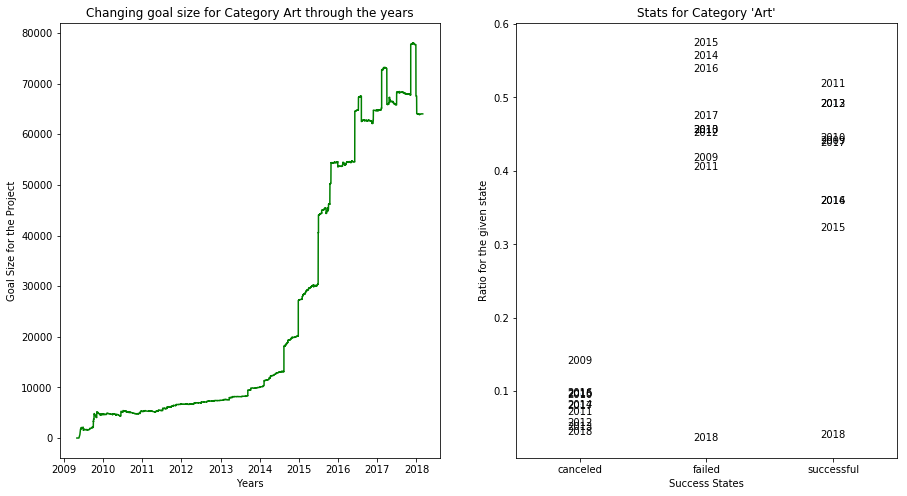

In [14]:
plot_cat_analysis(moving_avgs, deadlines, 'Art')

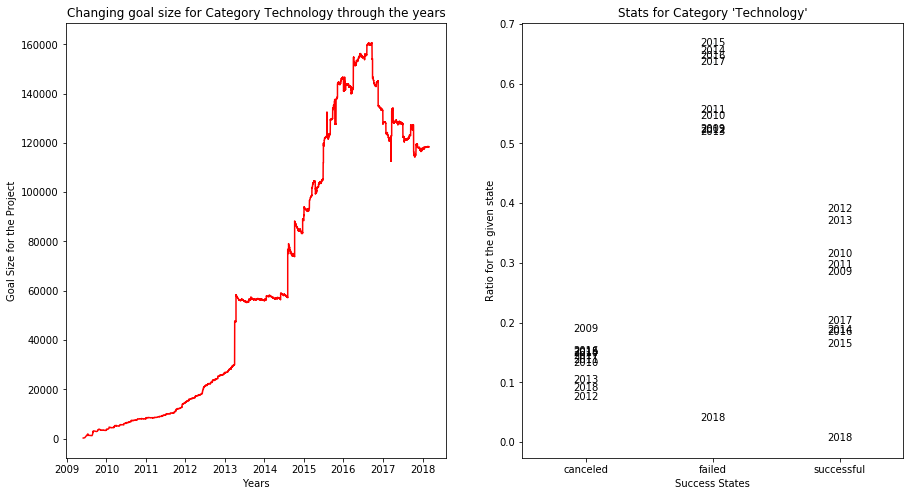

In [15]:
plot_cat_analysis(moving_avgs, deadlines, 'Technology')

ATTENTION: The "Changing goal size for Category ... through the years" plot has different y-label ticks! <br>
One can see, that the Category "Art" was the most successful between 2009 and 2013. At this time, the project goal sizes were much lower; The three most unsuccessful years were 2014, 2015 and 2016 (followed by 2017) - those are the years in which the prices rocketed. <br>
The Category "Technology" is not as cristal clear as the category "Art" regarding the statistic, but it still can be observed that the projects were less successful in times were the projects reached a certain goal size (since 2014 the projects have a mean goal size of above 60,000 USD). <br>
Additionally, it's interesting to see that the earlier years (when Projects had a longer project runtime) were in general more successful - mabye the project initiators need longer project runtimes to succeed than they think..

---
<a id='result'></a>
## 7.) Results

As the above plots show, successful Projects show some characteristics:
- some categories are much more likely to succeed than others (e.g. Art vs. Technology)
- smaller projects with lower goal sizes are more likely to succeed than complex projects
- the goal sizes of projects increased over time - the success ratio on the other hand rather decreased
- project runtimes get smaller, maybe they should again increase the time needed

If I'd initiate a project on Kickstarter, it'd probably be an Art Project with a goal size of roughly 5,000 USD and a project runtime of 40 days. Given the above statistics, it'd have a higher chance of success.
HOWEVER: Those insights are only given by some statistical numbers and plots; not taken into account in this analysis is the kind of person behind the project; Of course the projects success rate depends highly on this "Variable" ;)